In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<br>
# Part 1 ‑ Exploratory data analysis


In [91]:
data = pd.read_json('logins.json')
print(data.shape)
data['year'] = data['login_time'].dt.strftime('%Y').astype(int)
data['month'] = data['login_time'].dt.strftime('%m').astype(int)
data['day'] = data['login_time'].dt.strftime('%d').astype(int)
data['hour'] = data['login_time'].dt.strftime('%H').astype(int)
data['minute'] = data['login_time'].dt.strftime('%M').astype(int)
data['weekday'] = data['login_time'].dt.strftime('%A')
data['count'] = 1
data.head()

(93142, 1)


login_time  year  month  day  hour  minute   weekday  count
0 1970-01-01 20:13:18  1970      1    1    20      13  Thursday      1
1 1970-01-01 20:16:10  1970      1    1    20      16  Thursday      1
2 1970-01-01 20:16:37  1970      1    1    20      16  Thursday      1
3 1970-01-01 20:16:36  1970      1    1    20      16  Thursday      1
4 1970-01-01 20:26:21  1970      1    1    20      26  Thursday      1

In [56]:
df = data.copy()
#change minute to 15 min interval
df['minute'] = df['minute'] //15*15
#groupby
df = df.groupby(['year','month','day','hour','minute']).sum().reset_index()
#make new datetime object
df['date'] = pd.to_datetime(df[['year','month','day','hour','minute']])
df.head()

year  month  day  hour  minute  count                date
0  1970      1    1    20       0      2 1970-01-01 20:00:00
1  1970      1    1    20      15      6 1970-01-01 20:15:00
2  1970      1    1    20      30      9 1970-01-01 20:30:00
3  1970      1    1    20      45      7 1970-01-01 20:45:00
4  1970      1    1    21       0      1 1970-01-01 21:00:00

date  count
0 1970-01-01 20:00:00      2
1 1970-01-01 20:15:00      6
2 1970-01-01 20:30:00      9
3 1970-01-01 20:45:00      7
4 1970-01-01 21:00:00      1

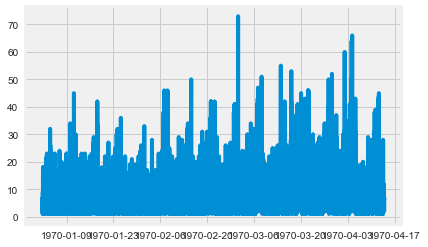

In [57]:
df = df[['date','count']]
fig= plt.figure(figsize=(6,4))
plt.plot(df['date'],df['count'])
df.head()

In [58]:
dff = data['login_time']
dff = dff.reset_index().set_index('login_time')
dff = dff.resample('15min').count()
dff.head()

index
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

## look at day cycles

In [59]:
day_dict = { 'nothing':0,
            'Monday': 1,
            'Tuesday':2,
            'Wednesday':3,
            'Thursday':4,
            'Friday':5,
            'Saturday':6,
            'Sunday':7
}
day_list = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
data['weekdayn'] = data['weekday'].map(lambda x: day_dict[x])
data.head()

login_time  year  month  day  hour  minute   weekday  count  \
0 1970-01-01 20:13:18  1970      1    1    20      13  Thursday      1   
1 1970-01-01 20:16:10  1970      1    1    20      16  Thursday      1   
2 1970-01-01 20:16:37  1970      1    1    20      16  Thursday      1   
3 1970-01-01 20:16:36  1970      1    1    20      16  Thursday      1   
4 1970-01-01 20:26:21  1970      1    1    20      26  Thursday      1   

   weekdayn  
0         4  
1         4  
2         4  
3         4  
4         4

In [60]:
df = data.copy()
df = df.groupby('weekdayn')['count'].sum().reset_index()
df

weekdayn  count
0         1   8823
1         2   9268
2         3  10339
3         4  11960
4         5  15208
5         6  19377
6         7  18167

(0, 22500)

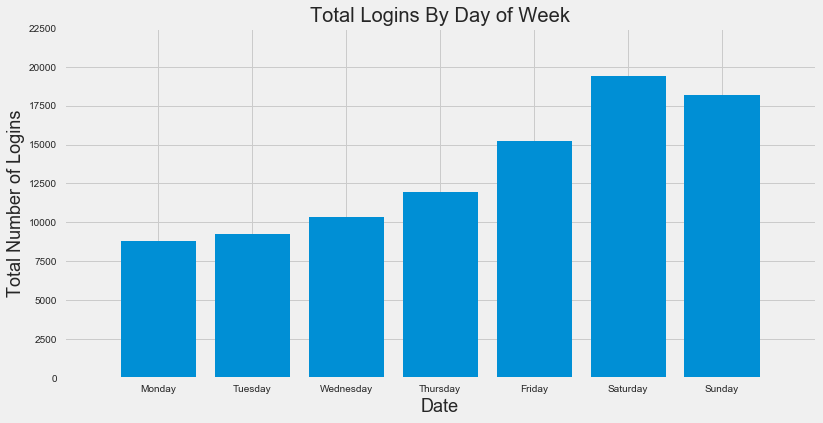

In [61]:
X = df.weekdayn
y = df['count']
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
plt.bar(X,y)
plt.ylabel('Total Number of Logins',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.title('Total Logins By Day of Week')
plt.xlim(0,8)
ax.set_xticklabels([''] + day_list)
plt.ylim(0,22500)

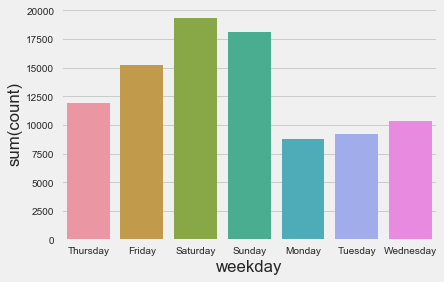

In [62]:
import seaborn as sns
sns.barplot(data=data,x='weekday',y='count',estimator=sum)

## look at trend over time

In [63]:
sorted(list(data.month.unique()))

[1, 2, 3, 4]

## Data Quality Issues
### There are only months Jan, Feb, Mar, Apr
### Accidently listed quarters instead of months?

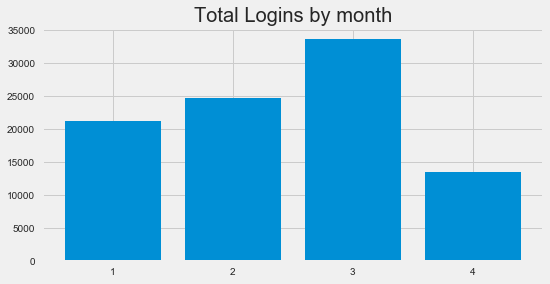

In [65]:
def bytime(data,period):
    df = data.groupby(period).sum().reset_index()
    fig = plt.figure(figsize=(8,4))
    ax = plt.subplot(111)
    plt.bar(df[period],df['count'])

    plt.xticks(np.arange(data[period].min(),data[period].max()+1))
    plt.title('Total Logins by '+period)

bytime(data,'month')

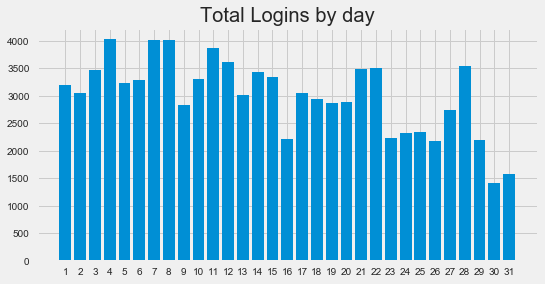

In [66]:
bytime(data,'day')

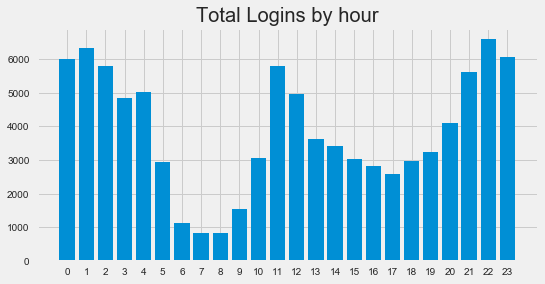

In [67]:
bytime(data,'hour')

<br>
# Part 2 ‑ Experiment and metrics design

#### The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

#### However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

    *After adjusting for seasonality, the metric of success that we will use is Cost Per Toll.  This is represented by X divided by Y, where:*
    - *X = Revenue Lost (Revenue Before - Revenue After)*
    - *Y = Increase in number of tolls (Total Tolls After - Total Tolls Before)*
    <br><br>
    
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
 1. How you will implement the experiment?<br>
 *If historical records are available, we will figure out the seasonality adjustments.  Then, before we begin offering reimbursement, we will record two metrics for 3 months before implementing reimbursement, and then for three months after the reimbursement is implemented.  Using these records, we can figure out our success metric.  The two metrics we record are:*
    - *The number of tolls per day*
    - *The percentage of tolls by driver partners*<br><br>
 
 2. What statistical test(s) you will conduct to verify the significance of the observation?<br>
 *We will conduct T tests for significance with a 95% confidence interval, and check to see if there is a difference between the mean values of total tolls, for each day of the week, before and after the experiment.*<br>
 *We will also calculate our metric of Cost Per Toll.*<br><br>
 
 3. How you would interpret the results and provide recommendations to the city operations team along with any caveats?<br>
 *If the T test determines that there is no difference between the mean values before and after the experiment for any of the days, then we will not recommend keeping the toll reimbursement, as the city would incur a cost, with no perceived benefit.*<br>
 *If the T test results in rejection of null hyptothesis for any of the days, then we will look to see what the Cost Per Toll metric is for those days.*<br>
 ***We will recommend that the city offers toll reimbursement rule only for days where Cost Per Toll is less than the actual cost of the toll.***<br>
 *We anticipate that the increase will be the strongest during the weekend*
 

<br>
# Part 3 ‑ Predictive modeling

In [80]:
import json

json_data = open('ultimate_data_challenge.json')
df = pd.DataFrame(json.load(json_data))

print(df.shape)
list(df.columns)

(50000, 12)


['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'city',
 'last_trip_date',
 'phone',
 'signup_date',
 'surge_pct',
 'trips_in_first_30_days',
 'ultimate_black_user',
 'weekday_pct']

#### Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

#### We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

- Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [98]:
#change to datetime
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
# We can see that the current date is 07/01 
df['last_trip_date'].sort_values(ascending=False).head()

45357   2014-07-01
22735   2014-07-01
14473   2014-07-01
38651   2014-07-01
45126   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

In [131]:
# Therefore, a user will be considered "retained" if they took a trip on or after 06/01
retained_date = pd.datetime(2014,6,1)
cond1 = df['last_trip_date'] >= retained_date
df['retained'] = 0
df.loc[cond1,'retained'] = 1

In [173]:
#define retained and not retained, and get means for each
retained = df.loc[df['retained']==1]
not_retained = df.loc[df['retained']==0]
retained_means = pd.DataFrame(retained.mean(),columns=['means'])
not_retained_means = pd.DataFrame(not_retained.mean(),columns=['means'])
#take the difference of the means
difference_means = pd.DataFrame(retained.mean() - not_retained.mean(),columns=['means'])
difference_means

means
avg_dist               -1.093150
avg_rating_by_driver   -0.024692
avg_rating_of_driver   -0.014627
avg_surge              -0.001530
surge_pct               0.486058
trips_in_first_30_days  1.647836
ultimate_black_user     0.205110
weekday_pct             0.742003
retained                1.000000

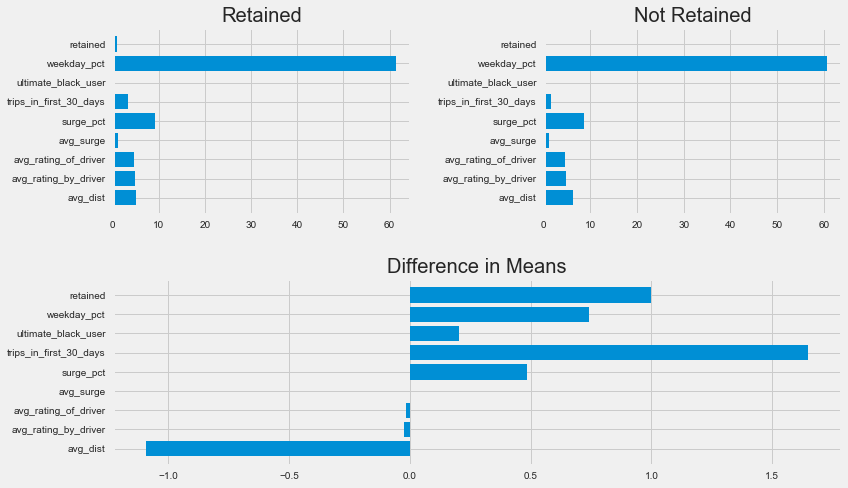

In [200]:
#plot the means of each, and the difference in means


def plot_means(df,title,ax):
    X = np.arange(1,len(df)+1)
    y = df['means']
    plt.barh(X,y)
    ax.set_title(title)
    plt.yticks(X)
    ax.set_yticklabels(list(difference_means.index))
    
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(221)
plot_means(retained_means,'Retained',ax1)

ax2 = plt.subplot(222)
plot_means(not_retained_means,'Not Retained',ax2)

ax3 = plt.subplot(212)

plot_means(difference_means,'Difference in Means',ax3)

plt.tight_layout(h_pad=2,w_pad=2)

- Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

- Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).